In [111]:
from math import sqrt,ceil,inf
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
import networkx as nx
from torchinfo import summary
import pickle

In [46]:
def findball(tree, center, radius):
    """Find all nodes within distance < radius from center."""
    visited = {center}
    queue = deque([(center, 0)])
    
    while queue:
        node, dist = queue.popleft()
        if dist < radius:
            for neighbor in tree[node]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + 1))
    return visited

def compute_covering_brute(tree, r=0, burning=set(), burnt=set(), bn=inf):
    # If everything is covered
    if len(burning) == len(tree):
        return burnt, len(burnt)

    # Prune if we can't do better
    if len(burnt) >= bn:
        return set(tree.keys()), len(tree)

    best_covering = set(tree.keys())
    best_bn = bn

    to_choose = sorted(
        set(tree) - {b[0] for b in burnt},
        key=lambda node: -len(tree[node])  # sort by degree, descending
    )

    for node in to_choose:
        ball = findball(tree, node, r)
        new_burning = burning.union(ball)
        new_burnt = burnt.union({(node,r)})
        candidate_covering, candidate_bn = compute_covering_brute(tree, r + 1, new_burning, new_burnt, best_bn)

        if candidate_bn < best_bn:
            best_covering = candidate_covering
            best_bn = candidate_bn

    return best_covering, best_bn

In [3]:
def to_adjacency(nodes,edges):
    '''Takes an int nodes and list of tuples edges and return adjacency form of the tree'''
    adj = {i:[] for i in range(nodes)}
    for (x,y) in edges:
        adj[x]+= [y]
        adj[y]+= [x]
    return adj
    
def graph_edges(tree):
    edges = []
    for node in tree:
        for adjacent in tree[node]:
            if (adjacent, node) not in edges:
                edges.append((node,adjacent))
    return edges
#first initialise the offspring distribution (zeta): p_0, p_1, ... p_k
def zeta_unspecified(randweight=10, tolerance=10**(-6)):
    T = 1
    p = []
    while T > 0:
        newp = random.random()/randweight
        if T >= newp:
            T = T - newp
            p.append(newp)
        else:
            p.append(T)
            T = 0
    assert(-tolerance <= sum(p) - 1 <= tolerance)
    return p


# a zeta where the expected number of children is 1, this is called a critical GW process
zeta_critical_example1 = [0.4, 0.3, 0.2, 0.1]
zeta_critical_example2 = [0.3, 0.4, 0.3]

##########################################################################################

#next we use the previous code to make a zeta and generate a GW tree of specified size n
def generate_GW(zeta, n, seed=None):
    if seed is not None:
        random.seed(seed)
        
    kidlist = list(range(len(zeta)))  # Values 0, 1, ..., max children
    edges = set()
    parent = 0
    upper = 1  # First unused node ID
    active_nodes = [0]  # List of nodes to expand (acts like a queue)

    while active_nodes and upper < n:
        parent = active_nodes.pop(0)
        nchild = random.choices(kidlist, weights=zeta, k=1)[0]

        for _ in range(nchild):
            if upper >= n:
                return (n, edges)
            edges.add((parent, upper))
            active_nodes.append(upper)
            upper += 1

    return (upper, edges)


In [49]:

def generate_uniform_tree(n):
    """
    Generate a uniform random tree on n nodes using a random Prufer sequence.
    Nodes are labeled 0 to n-1.
    """
    if n == 1:
        return nx.Graph()  # single node tree with no edges
    
    # Generate a random Prufer sequence of length n-2
    prufer_seq = [random.randint(0, n-1) for _ in range(n-2)]
    
    # Decode Prufer sequence into a tree (list of edges)
    # Algorithm adapted from Prufer sequence decoding:
    degree = [1] * n
    for node in prufer_seq:
        degree[node] += 1
    
    edges = []
    # Find the smallest node with degree 1
    leaf = 0
    while leaf < n and degree[leaf] != 1:
        leaf += 1
    
    for node in prufer_seq:
        edges.append((leaf, node))
        degree[leaf] -= 1
        degree[node] -= 1
        
        if degree[node] == 1 and node < leaf:
            leaf = node
        else:
            leaf += 1
            while leaf < n and degree[leaf] != 1:
                leaf += 1
    
    # Add the last edge
    u, v = [i for i in range(n) if degree[i] == 1]
    edges.append((u, v))
    
    # Create and return the tree graph
    tree = nx.Graph()
    tree.add_nodes_from(range(n))
    tree.add_edges_from(edges)
    return tree
edges = generate_uniform_tree(5).edges
adj = to_adjacency(5,edges)
print(edges)
print(adj)

[(0, 1), (0, 4), (2, 3), (3, 4)]
{0: [1, 4], 1: [0], 2: [3], 3: [2, 4], 4: [0, 3]}


In [5]:
# Define the functions from the last cell
def plot_tree(edges):
    def get_positions(node, depth=0, pos={}, x=0, dx=1):
        if node not in pos:
            pos[node] = (x, -depth)
            children = [v for u, v in edges if u == node]
            if children:
                dx = dx / len(children)
                next_x = x - dx * (len(children) - 1) / 2
                for i, child in enumerate(children):
                    pos = get_positions(child, depth + 1, pos, next_x + i * dx, dx)
        return pos

    def draw_tree(ax, edges, pos):
        for u, v in edges:
            x_values = [pos[u][0], pos[v][0]]
            y_values = [pos[u][1], pos[v][1]]
            ax.plot(x_values, y_values, 'gray')

        for node, (x, y) in pos.items():
            ax.scatter(x, y, c='skyblue', s=100)
            ax.text(x, y, str(node), fontsize=12, ha='center', va='center')

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_axis_off()

    root = 0
    pos = get_positions(root)
    draw_tree(ax, edges, pos)

    plt.show()


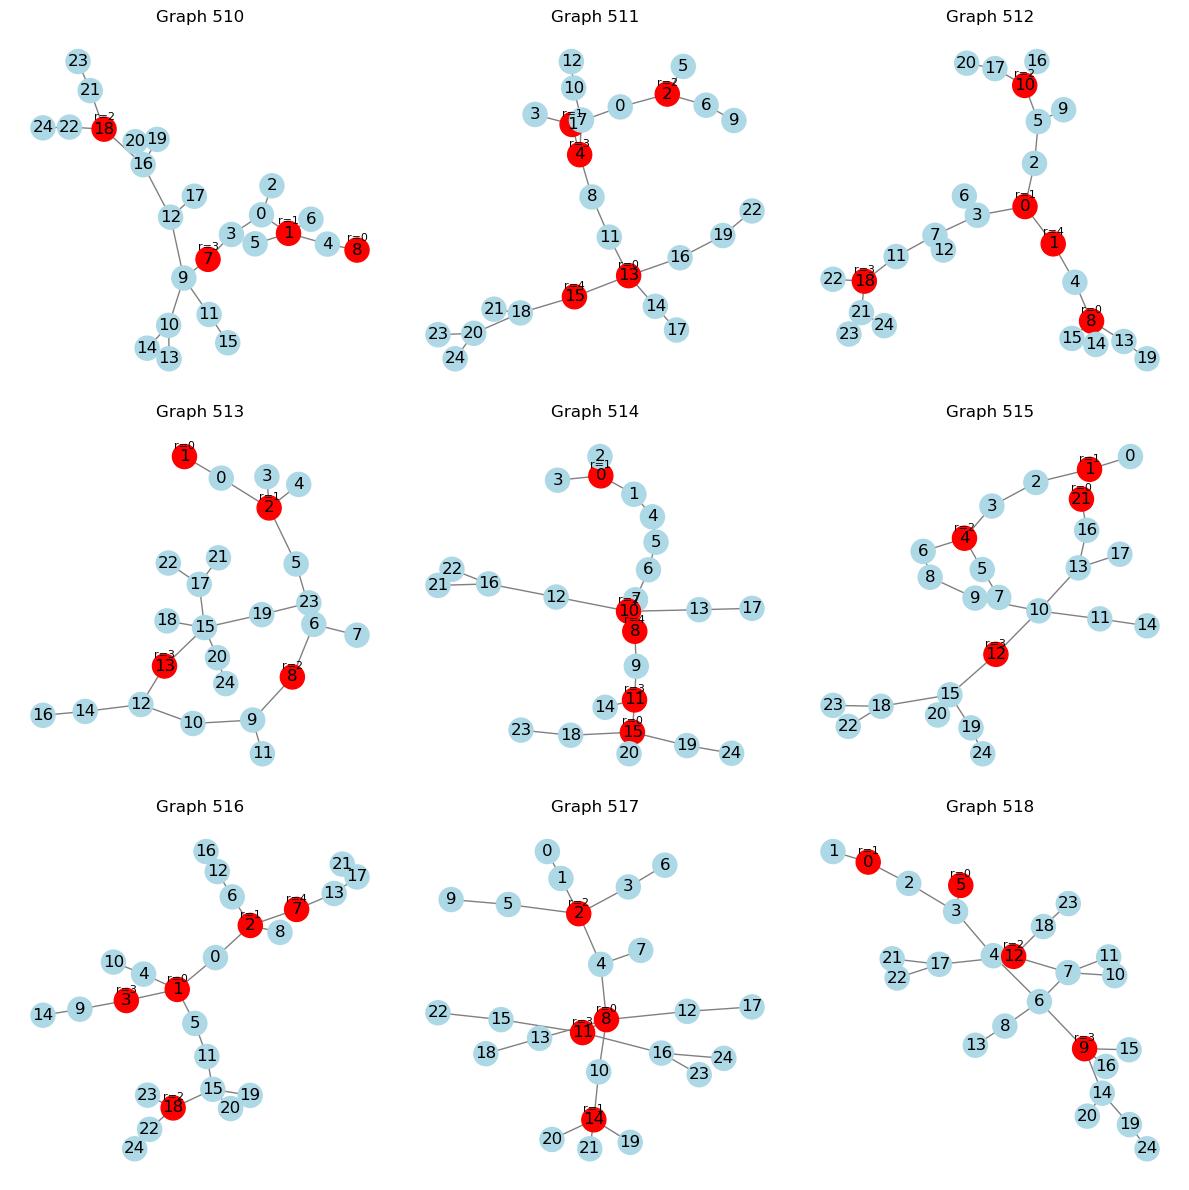

In [122]:
instances = 510
with open('data_4000(2).pkl', 'rb') as file:
    X, y = pickle.load(file)

edges = [graph_edges(X[i]) for i in range(instances, instances+9)]
trees = [nx.Graph(edge) for edge in edges]

plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    G = trees[i]
    pos = nx.spring_layout(G, seed=42)
    
    # Get ball centers and radii
    ball_info = y[instances + i]  # set of (node, radius)
    
    # Compute all nodes covered by any ball
    covered_nodes = set()
    for center, radius in ball_info:
        reachable = nx.single_source_shortest_path_length(G, center, cutoff=radius)
        covered_nodes.update(reachable.keys())
    
    # Build color map:
    node_colors = []
    for node in G.nodes:
        if node in dict(ball_info):  # Ball center
            node_colors.append('red')
        elif node in covered_nodes:
            node_colors.append('lightblue')
        else:
            node_colors.append('grey')
    
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray')

    # Annotate ball centers with radius
    for center, radius in ball_info:
        x, y_pos = pos[center]
        plt.text(x, y_pos + 0.05, f"r={radius}", fontsize=8, ha='center', color='black')
    
    plt.title(f"Graph {instances + i}")
    plt.axis('off')

plt.tight_layout()
plt.show()
counts = [X.count(X[i]) for i in range(len(X))]

In [75]:
# Execute the final cell to reproduce the error
n = 25
bn = ceil(sqrt(n))
Trees = X
print(Trees[-1])
labels = y
data_size = 2000

lambda_ = 0.92
k_values = np.arange(0, 11)
zeta = poisson.pmf(k_values, mu=lambda_)
print(zeta)
print(bn-1)
while len(Trees)<data_size:
    tree = to_adjacency(n,generate_uniform_tree(n).edges())
    covering,best_bn = compute_covering_brute(tree)
    Trees.append(tree)
    labels.append(covering)
X = Trees
y = labels

{0: [9, 5, 6], 1: [12, 18], 2: [13, 19], 3: [16, 19, 7], 4: [7, 10], 5: [0, 17], 6: [0, 23], 7: [3, 4, 20], 8: [22, 21], 9: [0], 10: [4, 24], 11: [23, 13], 12: [1], 13: [2, 11, 14], 14: [13], 15: [19], 16: [3, 18], 17: [5], 18: [1, 16], 19: [2, 3, 15], 20: [7], 21: [8, 23], 22: [8], 23: [6, 11, 21], 24: [10]}
[3.98519041e-01 3.66637518e-01 1.68653258e-01 5.17203325e-02
 1.18956765e-02 2.18880447e-03 3.35616686e-04 4.41096215e-05
 5.07260648e-06 5.18533107e-07 4.77050458e-08]
4


In [106]:
class GNN(nn.Module):
    def __init__(self,din,dh,n_p):
        super().__init__()
        self.dh = dh
        self.din = din
        self.n_p = n_p
        
        # Encoder:
        self.W_E = nn.Linear(din + dh, dh, bias=True)


        # Processor:
        self.W_M = nn.ModuleList([nn.Linear(2*dh,dh, bias=True) for _ in range(n_p)])
        self.W_P = nn.ModuleList([nn.Linear(2*dh,dh,bias=True) for _ in range(n_p)])

        # Decoder
        self.W_D = nn.Linear(2*dh,1,bias=True)

    def forward(self,x,h,edge_index):
        
        n = x.shape[0]
        # encode
        z = self.W_E(torch.cat([x,h],dim=1)) 
        h = z.clone()
        # GNN
        for k in range(self.n_p):
            h_i = h[edge_index[0]]
            h_j = h[edge_index[1]]

            m = F.relu(self.W_M[k](torch.cat([h_i,h_j],dim = 1) ))
            m_sum = torch.zeros_like(h)
            m_sum.index_add_(0,edge_index[0],m)
            h = h + F.relu(self.W_P[k](torch.cat([h,m_sum], dim = 1)))
        # decode
        l = self.W_D(torch.cat([z,h], dim=1)).squeeze(-1)

        # if the first element is one
        mask = (x[:,0] == 1)
        l[mask] = -inf

        p = F.softmax(l,dim = 0)

        return p, h

In [118]:
def encode_cover(sol,n,din):
    '''given a partial solution sol, will output the coresponding X matrix'''
    
    x = np.zeros((n,din),dtype = 'i')
    if len(sol) == 0:
        return x
    max_r = max(r for center,r in sol)
    for center,r in sol:
        x[center][0] = 1
        if r == 0: x[center][1] = 1
        if r == max_r: x[center][2] = 1
    return x


def adjacency_to_edge_index(adj_dict):
    edges = set()
    for u, neighbors in adj_dict.items():
        for v in neighbors:
            if u <= v:  # Add each edge once (sorted order)
                edges.add((u, v))
            else:
                edges.add((v, u))

    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_index
def adjacency_dict_to_nx(adj_dict):
    """
    Convert adjacency dictionary (undirected) to a NetworkX Graph.
    
    Args:
        adj_dict: dict where keys are nodes and values are iterables of neighbors
    
    Returns:
        G: networkx.Graph
    """
    G = nx.Graph()
    for node, neighbors in adj_dict.items():
        for nbr in neighbors:
            G.add_edge(node, nbr)  # automatically adds nodes if needed
    return G
def get_initial_h(G: nx.Graph, dh: int, device='cpu'):
    """
    Initialize hidden states `h` for nodes in graph G.
    
    Args:
        G: networkx Graph
        dh: hidden dimension size
        device: torch device
        
    Returns:
        h: torch.Tensor of shape (n_nodes, dh)
    """
    n = G.number_of_nodes()
    nodes = list(G.nodes)
    
    # Extract features (degree, clustering, pagerank)
    degree = np.array([G.degree(n) for n in nodes], dtype=np.float32)
    clustering = np.array(list(nx.clustering(G).values()), dtype=np.float32)
    pagerank = np.array(list(nx.pagerank(G).values()), dtype=np.float32)
    
    # Stack features: shape (n_nodes, 3)
    features = np.stack([degree, clustering, pagerank], axis=1)
    
    # Normalize features
    features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-6)
    
    # Convert to torch tensor
    features = torch.tensor(features, dtype=torch.float32, device=device)
    
    # If dh > number of features, project using a linear layer
    if dh != features.shape[1]:
        # Define a projection layer (can also be a small MLP)
        projection = torch.nn.Linear(features.shape[1], dh).to(device)
        with torch.no_grad():
            h = F.relu(projection(features))
    else:
        h = features
    
    return h

In [123]:
din = 3       # input feature size
dh = 32       # hidden dimension
n_p = 4       # number of GNN steps
n = 25

model = GNN(din, dh, n_p)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()  # adjust as needed

for epoch in range(100):
    print(epoch)
    total_loss = 0
    for tree,cover in [(X[i],y[i]) for i in range(len(X))]:
        cover = {r : center for (center,r) in cover}
        loss = 0
        edge_index = adjacency_to_edge_index(tree)
        h = get_initial_h(adjacency_dict_to_nx(tree),dh)
        for i in range(len(cover)):
            partial_cover = {(center,r) for (r,center) in cover.items() if r < i}
            next_center = cover[i]
            x = encode_cover(partial_cover,n,din)
            if isinstance(x, np.ndarray):
                x = torch.tensor(x, dtype=torch.float)
            p, h = model(x, h, edge_index)
            if i != 0:
                loss += -torch.log(p[next_center] + 1e-8)  
        # gradient update backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(total_loss)
    

0
45933.936647892
1
44437.66154074669
2
44145.18252849579
3
43915.0010766983
4
43820.82702445984
5
43688.7308139801
6
43648.772022008896
7
43564.832057237625
8
43516.607817173004
9
43532.01915717125
10
43576.38987612724
11
43433.36357045174
12
43460.84497153759
13
43536.241069316864
14
43504.18604576588
15
43461.56816458702
16
43366.51742231846
17
43385.21661412716
18
43347.25846660137
19
43365.70393061638
20
43403.13656902313
21
43305.19816160202
22
43249.9877910614
23
43493.049649477005
24
43301.119349718094
25
43367.27563405037
26
43392.90005874634
27
43379.74197077751
28
43332.84088563919
29
43411.73199594021
30
43283.28132367134
31
43345.41391646862
32
43185.12602972984
33
43357.84396147728
34
43360.46304106712
35
43269.57160806656
36
43451.60028553009
37
43273.96831405163
38
43358.838458418846
39
43393.80675137043
40
43257.48196065426
41
43318.192982673645
42
43264.08277320862
43
43287.576004743576
44
43850.56450796127
45
43277.29629659653
46
43350.604800224304
47
43369.107969760

KeyboardInterrupt: 